In [2]:
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image
import os
import os.path
from __future__ import print_function
import torch
import numpy as np
from skimage.transform import rescale
import random



IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]


def is_image_file(filename, filetypes=IMG_EXTENSIONS):
    return any(filename.endswith(extension) for extension in filetypes)


def make_dataset(dir, filetypes=IMG_EXTENSIONS):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname, filetypes):
                path = os.path.join(root, fname)
                images.append(path)

    return images


In [3]:

class BaseDataset(data.Dataset):

    ''' Datasets all have to follow the given format.'''

    def __init__(self):
        super(BaseDataset, self).__init__()

    def name(self):
        return 'BaseDataset'

    def initialize(self, opt):
        pass


def get_transforms(opt):
    transform_list = []
    if opt.resize_or_crop == 'resize_and_crop':
        # scale images to opt.loadSize using BICUBIC rule
        osize = [opt.loadSize, opt.loadSize]
        transform_list.append(transforms.Scale(osize, Image.BICUBIC))
        transform_list.append(transforms.RandomCrop(opt.fineSize))
    elif opt.resize_or_crop == 'crop':
        transform_list.append(transforms.RandomCrop(opt.fineSize))
    elif opt.resize_or_crop == 'scale_width':
        transform_list.append(transforms.Lambda(
            lambda img: __scale_width(img, opt.fineSize)))
    elif opt.resize_or_crop == 'scale_width_and_crop':
        transform_list.append(transforms.Lambda(
            lambda img: __scale_width(img, opt.loadSize)))
        transform_list.append(transforms.RandomCrop(opt.fineSize))

    #lambda te permite usar una funcion definida por el usuario como una transformacion 

    if opt.isTrain and not opt.no_flip:
        transform_list.append(transforms.RandomHorizontalFlip())

    transform_list += [transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)
    
# compose compone varias funciones juntas, admite una lista de transformaciones 

def __scale_width(img, target_width):
    ow, oh = img.size
    if (ow == target_width):
        return img
    w = target_width
    h = int(target_width * oh / ow)
    return img.resize((w, h), Image.BICUBIC)


In [5]:

def vox2tensor(img):
    ''' Converts a Numpy array (D x H x W x C) to a voxel Tensor
    ( C x D x H x W )
    '''
    if img.ndim == 4:
        img = img.transpose((3, 0, 1, 2))
        img = torch.from_numpy(img)
        if isinstance(img, torch.ByteTensor):
            return img.float().div(255)
        else:
            return img
    else:
        raise TypeError('vox should have 4 dimensions.')
    pass


def normalize3d(img, mean, std):
    ''' Normalizes a voxel Tensor (C x D x H x W) by mean and std. '''
    if len(mean) < 3 or len(std) < 3:
        raise TypeError('not enough means and standard deviations')
    for t, m, s in zip(img, mean, std):
        t.sub_(m).div_(s)
    return img



In [42]:

class VoxelDataset(BaseDataset):
    def initialize(self):
        self.dir_AB = r"C:\Users\ortma\Desktop\FACULTAD\PI\TENSORES PACIENTES"
        # go through directory return os.path for all images
        slice_filetype = ['.pt'] 
        self.AB_paths = sorted(make_dataset(self.dir_AB, slice_filetype))  # make_dataset te devuelve una lista con tutas de las imagenes que coincidan con las extensiones ingresadas
        
    def rgb_to_gray(self, tensor_ct, tensor_dosis):
        '''Reference images are CT scans with highlighted OARs and PTVs. The
        targets are dose intensity matrices.'''
        
        dose_val = (tensor_dosis).numpy()
        ct_img = (tensor_ct).numpy()
        #d, w, h, nc = ct_img.shape
        #assert (d, w, h) == dose_val.shape, 'size mismatch between dose and ct'
        
        # to handle aaron's weird uint format
        if dose_val.dtype == np.uint8 or dose_val.dtype == np.uint16:
            dose_val= dose_val / 256
        if ct_img.dtype == np.uint8 or ct_img.dtype == np.uint16:
            ct_img = ct_img / 256
    
        A = vox2tensor(ct_img).float()
        A = normalize3d(A, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

        B = torch.from_numpy(dose_val).float()
        B = B.unsqueeze(0) # se utiliza para agregar una dimensión adicional al tensor B en la posición 0
        B.sub_(0.5).div_(0.5)
        '''
        # flipping augments the dataset by flipping a bunch of the images.
        if (not self.opt.no_flip) and random.random() < 0.5:
            idx = [i for i in range(A.size(2) - 1, -1, -1)]
            idx = torch.LongTensor(idx)
            A = A.index_select(2, idx)
            B = B.index_select(2, idx)'''
        return A, B

    def __getitem__(self, index):
        
        AB_path = self.AB_paths[index]
       # Cargar el archivo utilizando el nombre de la variable
        loaded = torch.load(AB_path)
        
        # Acceder a los tensores por separado
        tensor_ct = loaded["imagen"]
        tensor_dosis = loaded["dosis"]
    
        A, B = self.rgb_to_gray(tensor_ct, tensor_dosis)
        
        return {'A': A, 'B': B, 'A_paths': AB_path, 'B_paths': AB_path}

    def __len__(self):
        return len(self.AB_paths)

    def name(self):
        return 'VoxelDataset'


# Crea una instancia de la clase VoxelDataset
voxel_dataset = VoxelDataset()
voxel_dataset.initialize()
# Llama al método initialize
lista = voxel_dataset.__getitem__(0)

tensor_ct = lista['A']

tensor_dosis = lista['B']

tensor_ct.size()


torch.Size([3, 123, 287, 375])

In [79]:
import torch
import torch.nn.functional as F

def trilinear_interpolation(tensor, target_size):
    # Redimensionar usando interpolación trilineal con el tamaño objetivo
    tensor_resized = F.interpolate(tensor.unsqueeze(0), size=target_size, mode='trilinear', align_corners=False).squeeze(0)
    return tensor_resized

# Definir el tamaño objetivo
target_size = [128,128,128]

# Realizar interpolación trilineal
tensor_trilinear = trilinear_interpolation(tensor_dosis, target_size)


# Verificar las formas originales y redimensionadas
print("Tensor original:", tensor_dosis.shape)
print("Tensor trilineal:", tensor_trilinear.shape)


Tensor original: torch.Size([1, 123, 113, 148])
Tensor trilineal: torch.Size([1, 128, 128, 128])


-----------------------------------------------------------------------------------------------------------
Mostramos el tensor rgb recortado


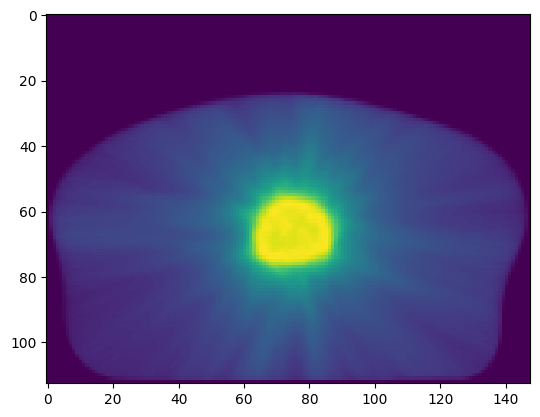

-----------------------------------------------------------------------------------------------------------


In [43]:
# graficamos los resultados obtenidos 
import matplotlib.pyplot as plt
print("-----------------------------------------------------------------------------------------------------------")
print("Mostramos el tensor rgb recortado")
    

corte = tensor_dosis[:, 50, :,:]
corte = corte.permute(1,2,0)
plt.imshow(corte)
plt.show()
                    
print("-----------------------------------------------------------------------------------------------------------")
